In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 200)

# Load data


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Original number of tickers: 246
Drop tickers: ['IRAO']
Start date = 2013-12-16
Filtered number of tickers: 30
Stocks: ['AFLT', 'ALRS', 'GCHE', 'HYDR', 'LKOH', 'LSRG', 'MGNT', 'MOEX', 'MRKC', 'MRKP', 'MSNG', 'MSRS', 'MTLR', 'MTLRP', 'MTSS', 'NVTK', 'PHOR', 'PIKK', 'POLY', 'RTKM', 'RTKMP', 'SBER', 'SBERP', 'TATN', 'TATNP', 'TGKA', 'TRMK', 'TRNFP', 'UTAR', 'VTBR']
From 2013-12-16 to 2023-05-10


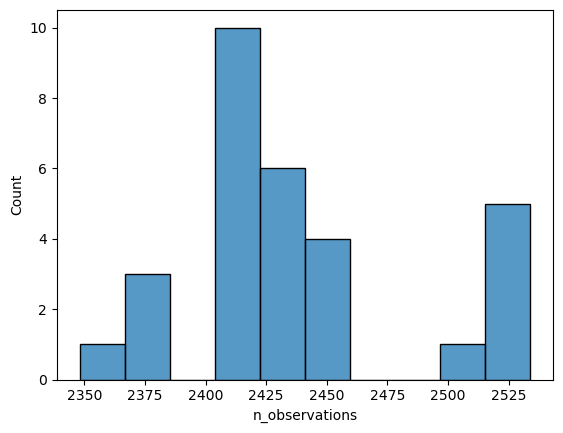

DataFrame size after merge: 2255


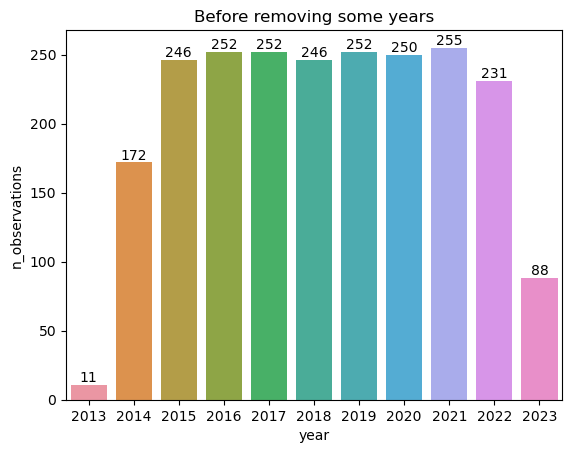

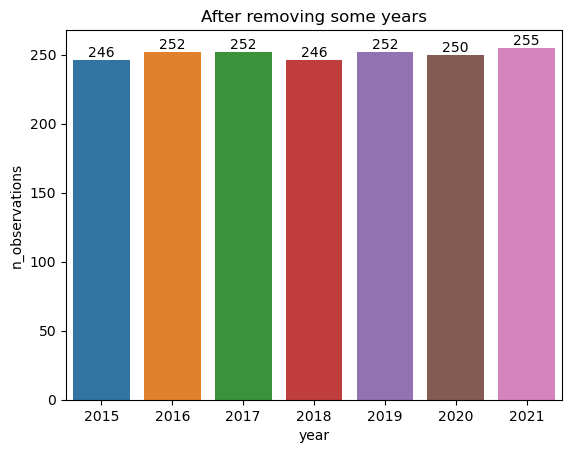

DataFrame size after removing some years: 1753

2015 year: 246 observations
2016 year: 252 observations
2017 year: 252 observations
2018 year: 246 observations
2019 year: 252 observations
2020 year: 250 observations
2021 year: 255 observations

Train: 1010. Test: 472. Test ratio: 0.3184885290148448


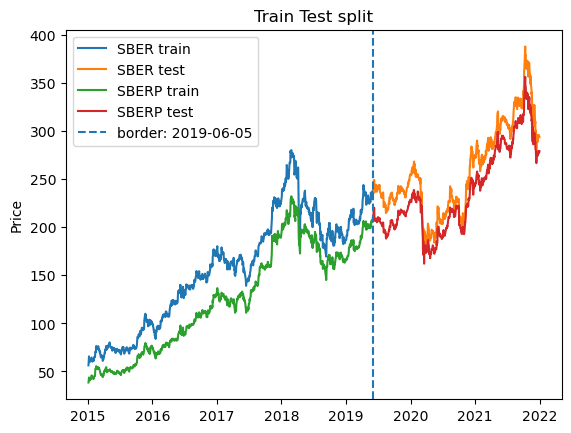

In [7]:
from library.dataset import load_train_test_dataset


observations_train, observations_test, df_price_train, df_price_test = load_train_test_dataset(verbose=True)

# Return and correlation/covariance matrix calculation


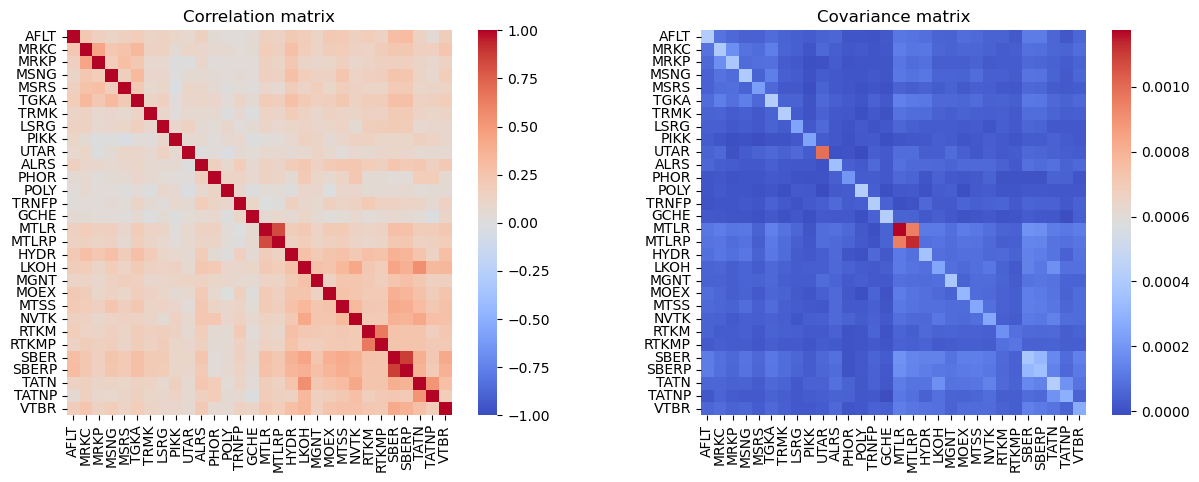

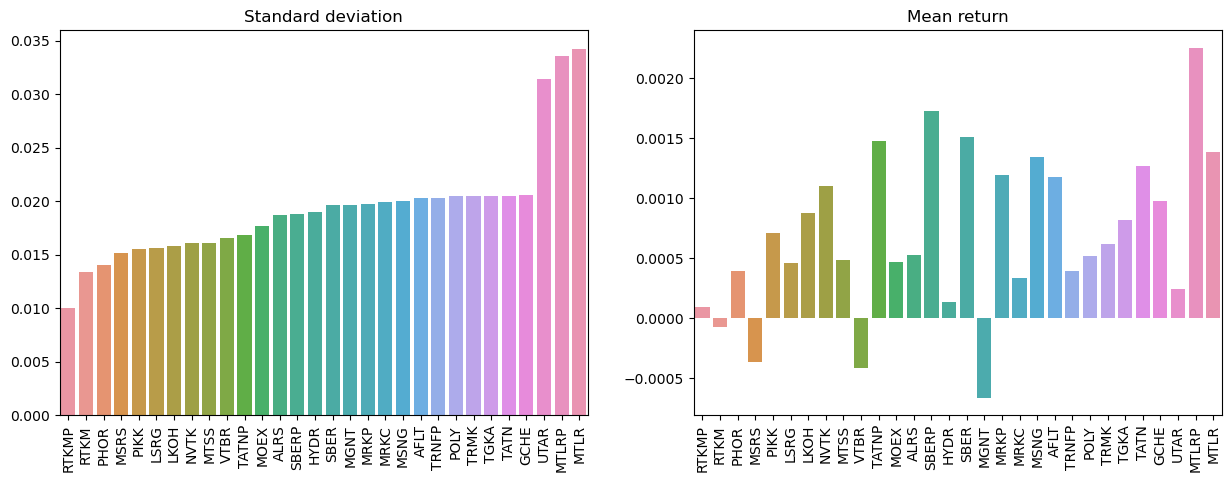

In [8]:
from library.correlations import get_returns_correlations, sort_corr, plot_correlations


def plot_corr_cov_returns_mean_std(df_price):
    correlations = get_returns_correlations(df_price)
    sorted_index = sort_corr(correlations.corr)

    # Plot correlations
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plot_correlations(correlations.corr, sorted_index)
    plt.title('Correlation matrix')
    plt.subplot(1, 2, 2)
    sns.heatmap(correlations.cov.loc[sorted_index, sorted_index], cmap='coolwarm', xticklabels=True, yticklabels=True, square=True)
    plt.title('Covariance matrix')
    plt.show()

    # Plot mean return and its standard deviation
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(5)

    sorted_index = sorted(correlations.index, key=lambda x: correlations.cov[x][x])
    sns.barplot(x=sorted_index, y=np.sqrt(np.diagonal(correlations.cov.loc[sorted_index, sorted_index])), ax=ax1)
    ax1.set_title('Standard deviation')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

    sns.barplot(x=sorted_index, y=correlations.returns[sorted_index].mean(axis=0), ax=ax2)
    ax2.set_title('Mean return')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

    plt.show()


plot_corr_cov_returns_mean_std(df_price_train)

# Sort correlation matrix for better vizualization


In [60]:
OBSERVATION_NUMBER = 100

correlations = get_returns_correlations(observations_train[OBSERVATION_NUMBER].df_price_train)
Sigma = correlations.corr
sorted_labels = sort_corr(Sigma)
print(correlations.returns.shape)

np.random.seed(0)
Sigma_random_normal = np.corrcoef(np.random.normal(size=correlations.returns.T.shape))

(90, 30)


# Remove market component from correlation matrix


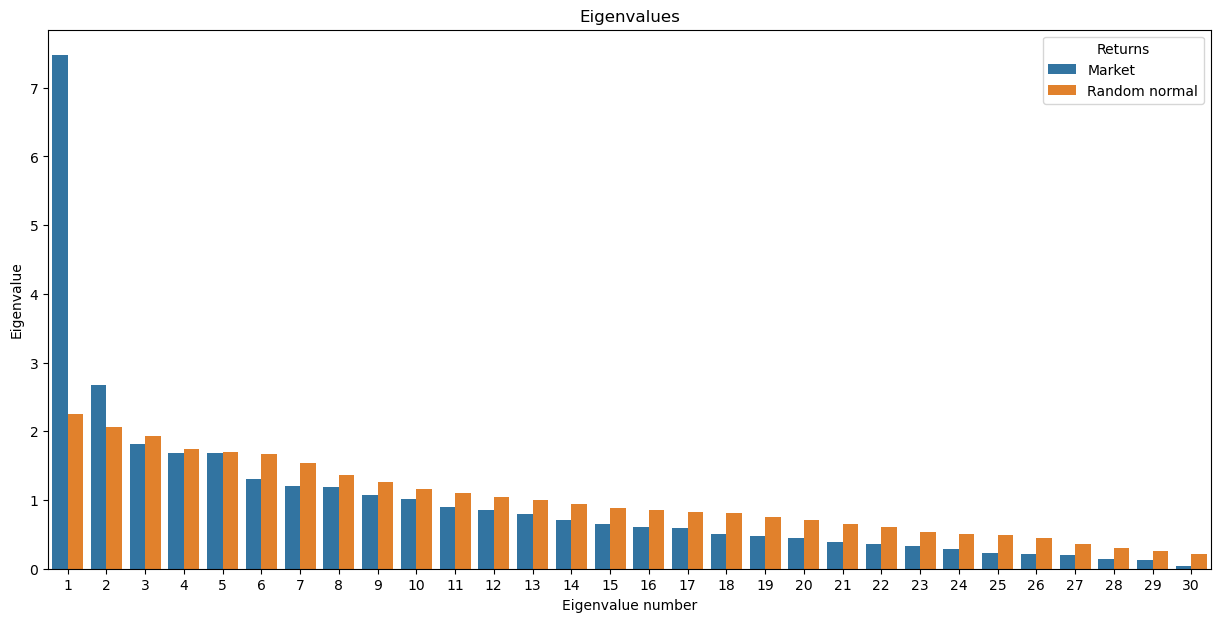

In [10]:
def plot_eigenvalues(Sigmas: list[pd.DataFrame], labels: list[pd.DataFrame]):
    S_for_Sigmas = pd.DataFrame(np.array([np.linalg.svd(Sigma)[1] for Sigma in Sigmas]).T, columns=labels)
    S_for_Sigmas['Id'] = np.arange(1, len(S_for_Sigmas) + 1)
    S_for_Sigmas = S_for_Sigmas.melt(id_vars='Id').rename(columns=str.title).rename(columns={'Variable': 'Returns'})

    plt.title('Eigenvalues')
    sns.barplot(S_for_Sigmas, x='Id', y='Value', hue='Returns')
    plt.gcf().set_figwidth(15)
    plt.gcf().set_figheight(7)
    plt.xlabel('Eigenvalue number')
    plt.ylabel('Eigenvalue')


plot_eigenvalues([Sigma, Sigma_random_normal], ['Market', 'Random normal'])

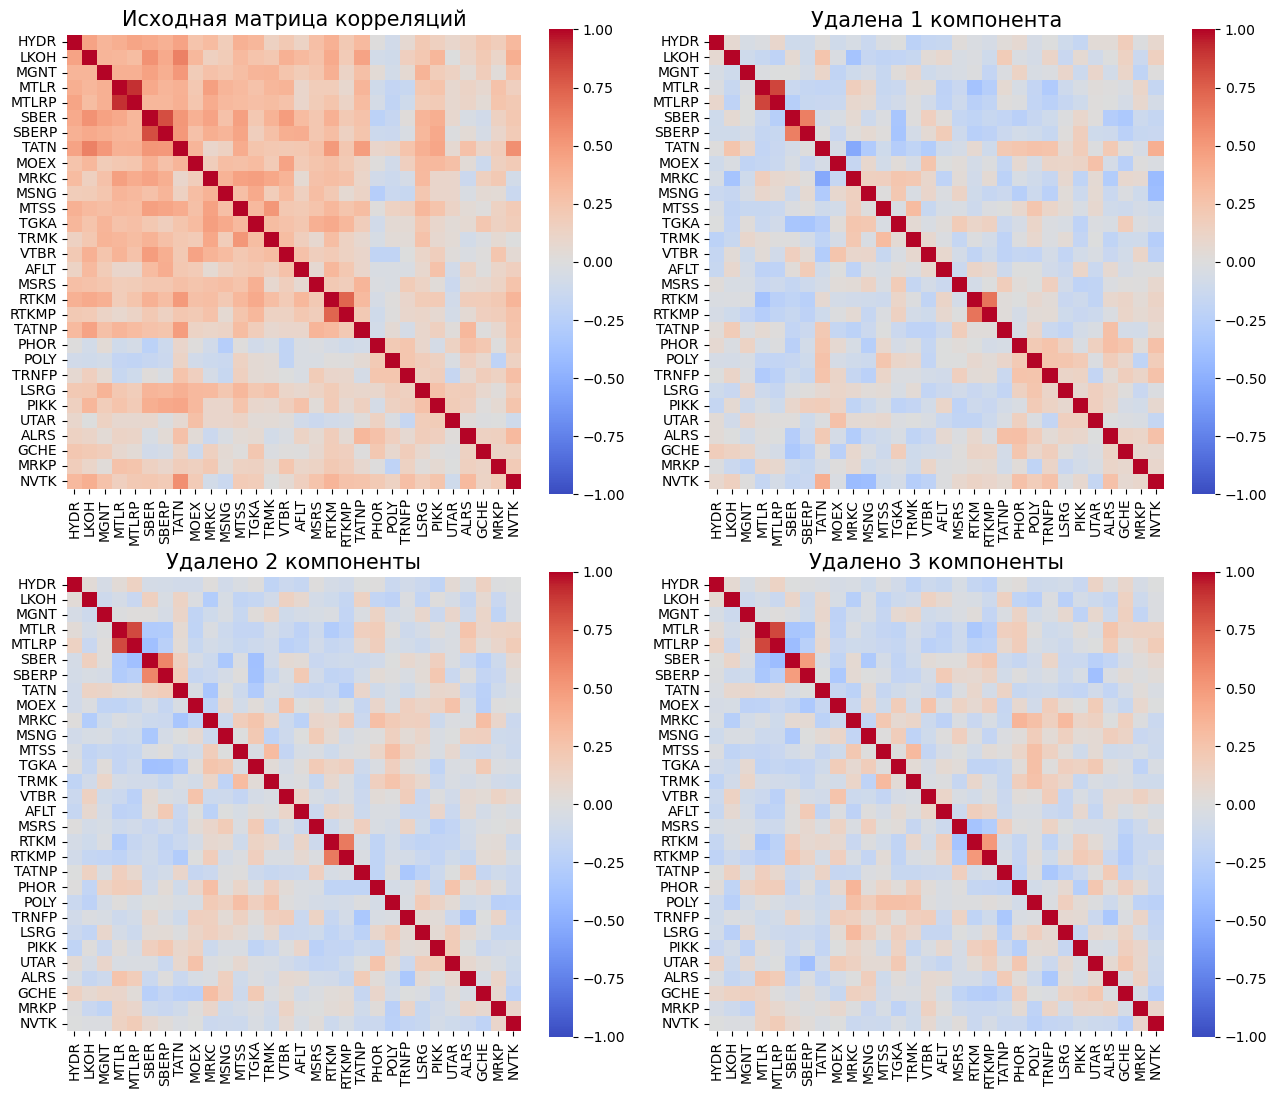

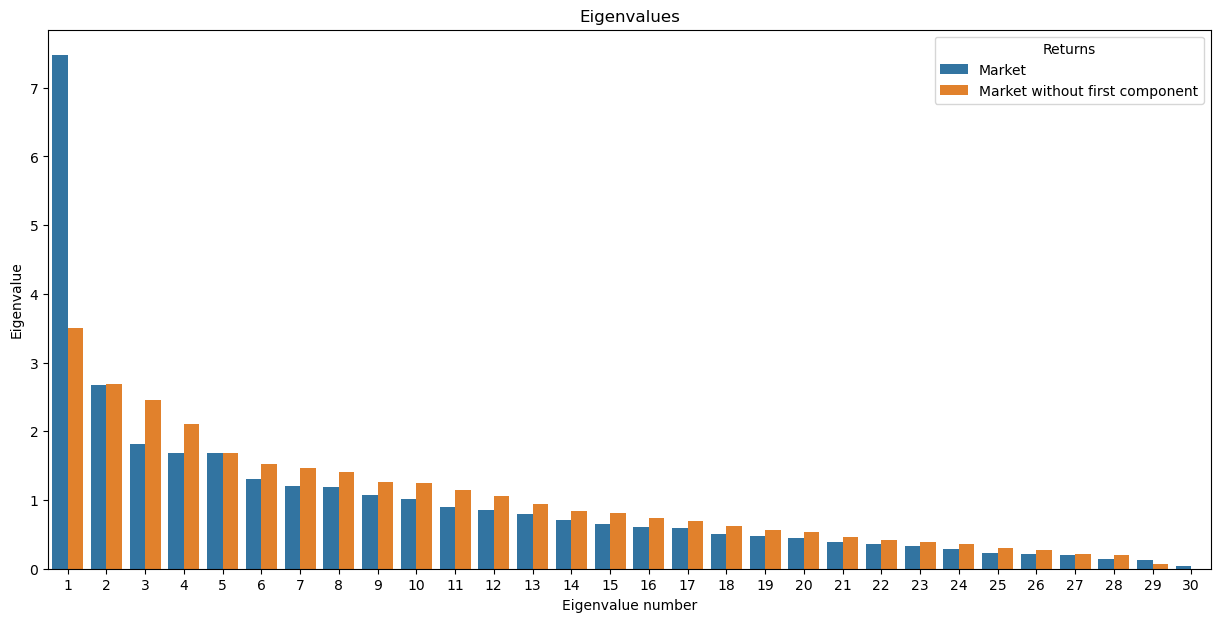

In [11]:
from library.correlations import detone, denoise, denoise_and_detone


def plot_detone_sigma(Sigma: pd.DataFrame, max_removed_components: int):
    n = round(np.sqrt(max_removed_components))
    assert n ** 2 == max_removed_components
    plt.subplots(n, n, figsize=(13, 11))
    TITLE_FONT_SIZE = 15
    msg = {
        0: 'Исходная матрица корреляций',
        1: 'Удалена 1 компонента'
    }
    msg.update({i: f'Удалено {i} компоненты' for i in range(2, max_removed_components)})
    for i in range(max_removed_components):
        Sigma_detoned = detone(Sigma, n_removed_components=i)
        plt.subplot(n, n, i + 1)
        plt.title(msg[i], fontsize=TITLE_FONT_SIZE)
        plot_correlations(Sigma_detoned, sorted_labels)
    plt.tight_layout()


plot_detone_sigma(Sigma, max_removed_components=4)
plt.savefig('../figures/market_components/market_components.png', bbox_inches='tight')
plt.show()

plot_eigenvalues([Sigma, detone(Sigma)], ['Market', 'Market without first component'])

Simga


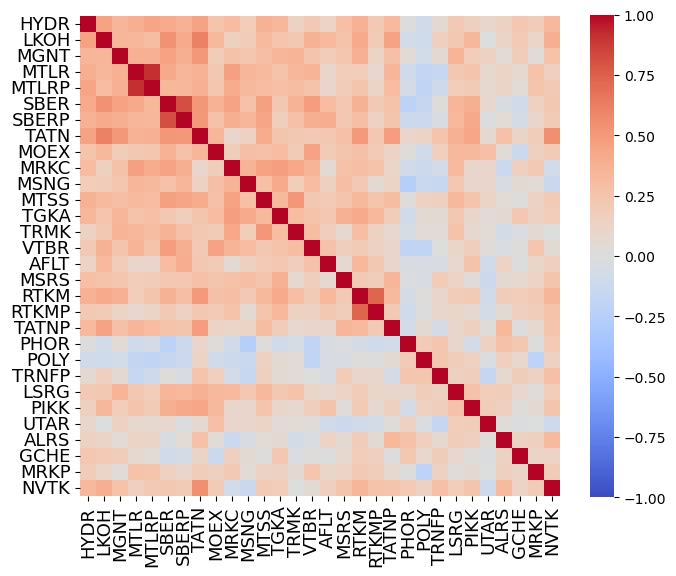

Simga_detoned


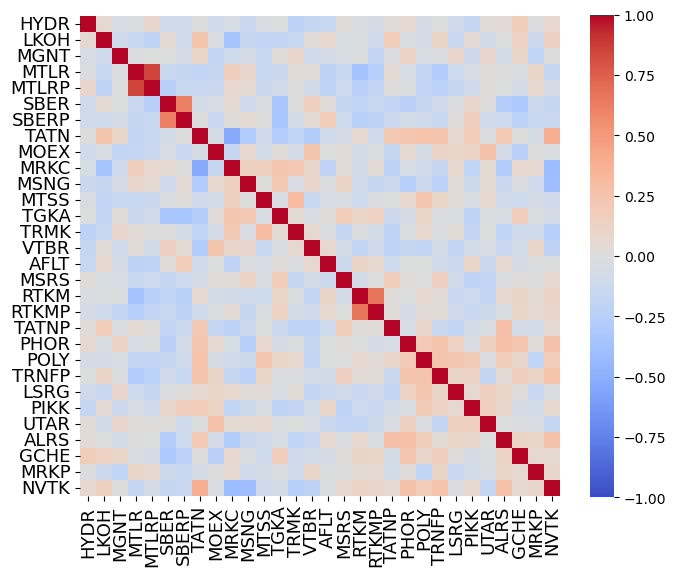

In [12]:
FONT_SIZE = 13
SHRINK = 0.74

print('Simga')
plt.figure(figsize=(7, 7))
heatmap = plot_correlations(Sigma, sorted_labels, cbar_kws={"shrink": SHRINK})
# heatmap = sns.heatmap(Sigma.loc[sorted_labels, sorted_labels], cmap='coolwarm', xticklabels=True, yticklabels=True, square=True, cbar_kws={"shrink": 0.75}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=FONT_SIZE)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig('../figures/detoning/original_matrix.png', bbox_inches='tight')
plt.show()

print('Simga_detoned')
plt.figure(figsize=(7, 7))
Sigma_detoned = detone(Sigma, n_removed_components=1)
heatmap = plot_correlations(Sigma_detoned, sorted_labels, cbar_kws={"shrink": SHRINK})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=FONT_SIZE)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig('../figures/detoning/detoned_matrix.png', bbox_inches='tight')
plt.show()

# Remove noise from correlation matrix


T = 90. N = 30. c = 0.3333333333333333
[7.47144443 2.67265963 1.81718218 1.6899338  1.6842677  1.31149865
 1.20552018 1.18489013 1.07738568 1.01359428 0.90130251 0.85791808
 0.80004565 0.71198404 0.64582884 0.60386671 0.59531384 0.51106429
 0.47848555 0.45170602 0.38646665 0.3665833  0.32723744 0.28228032
 0.23578689 0.21822319 0.19521579 0.13652914 0.12113274 0.04465234]
lambda_minus = 0.1786. lambda_plus = 2.4880
Sigma_random_normal


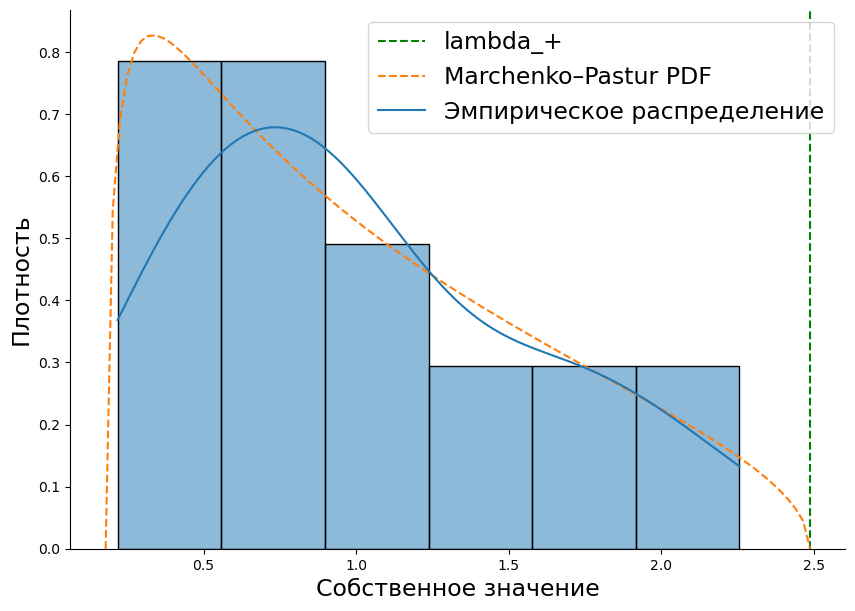

Sigma


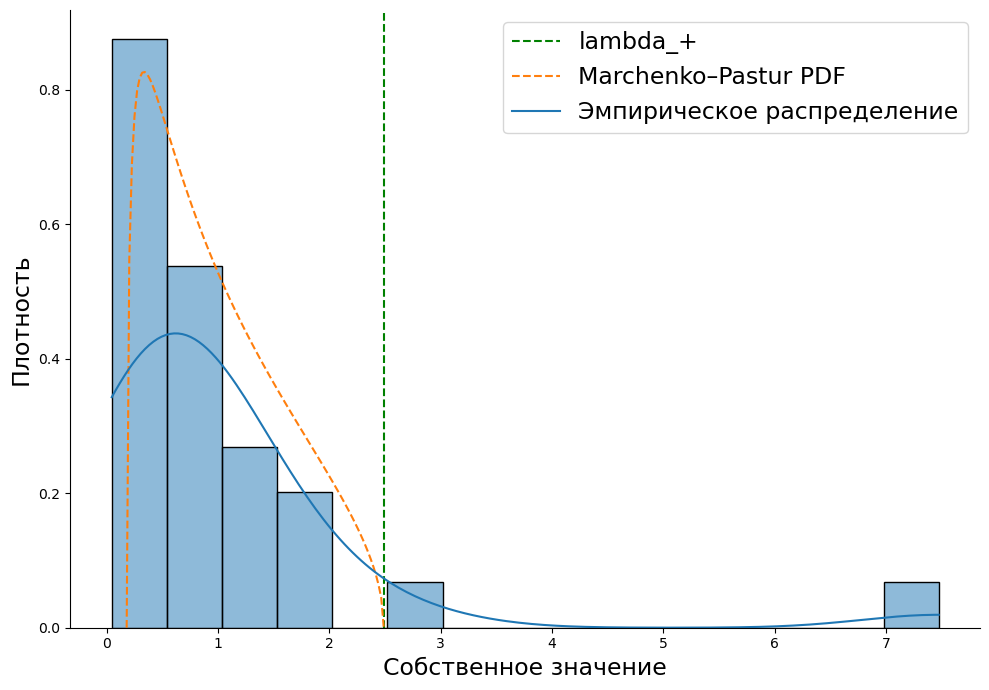

In [13]:
from library.correlations import get_marchenko_pastur_lambdas, marchenko_pastur_pdf


def plot_marchenko_pastur(df_price: pd.DataFrame, Sigma: pd.DataFrame, drop_zeros: bool = False, plot_lambda: bool = True):
    T, N = df_price.shape
    c = N / T
    # sigma = 1.0 for correlation matrix

    if plot_lambda:
        lambda_minus, lambda_plus = get_marchenko_pastur_lambdas(sigma=1, c=c)
        plt.axvline(lambda_plus, label='lambda_+', color='green', linestyle='dashed')

    theory_pdf = marchenko_pastur_pdf(sigma=1.0, c=c, n_points=100)
    plt.plot(theory_pdf, color='C1', linestyle='dashed', label='Marchenko–Pastur PDF')

    # Plot the estimated density
    U, S, VT = np.linalg.svd(Sigma)
    if drop_zeros:
        S = S[~np.isclose(S, 0.0)]
    sns.histplot(S, stat='density', kde=True, label='Эмпирическое распределение')
    plt.xlabel('Собственное значение', fontsize=17)
    plt.ylabel('Плотность', fontsize=17)
    # Add a legend with the correct label
    sns.despine()
    additional_labels = ['lambda_+'] if plot_lambda else []
    plt.legend(labels=additional_labels + ['Marchenko–Pastur PDF', 'Эмпирическое распределение'], fontsize=17)


TITLE_FONT_SIZE = 20
T, N = correlations.returns.shape
c = N / T
print(f'{T = }. {N = }. {c = }')
lambda_minus, lambda_plus = get_marchenko_pastur_lambdas(sigma=1, c=c)
U, S, VT = np.linalg.svd(Sigma)
print(S)
print(f'{lambda_minus = :.4f}. {lambda_plus = :.4f}')

print('Sigma_random_normal')
plt.figure(figsize=(10, 7))
np.random.seed(0)
plot_marchenko_pastur(correlations.returns, Sigma_random_normal)
plt.savefig('../figures/eigenvalues/normal_eigenvalues.png', bbox_inches='tight')
plt.show()

print('Sigma')
plt.figure(figsize=(10, 7))
plot_marchenko_pastur(correlations.returns, Sigma)
plt.tight_layout()
plt.savefig('../figures/eigenvalues/real_eigenvalues.png', bbox_inches='tight')
plt.show()

Remaining eigenvalues for denoised matrix: 2
Remaining eigenvalues for detoned and denoised matrix: 2


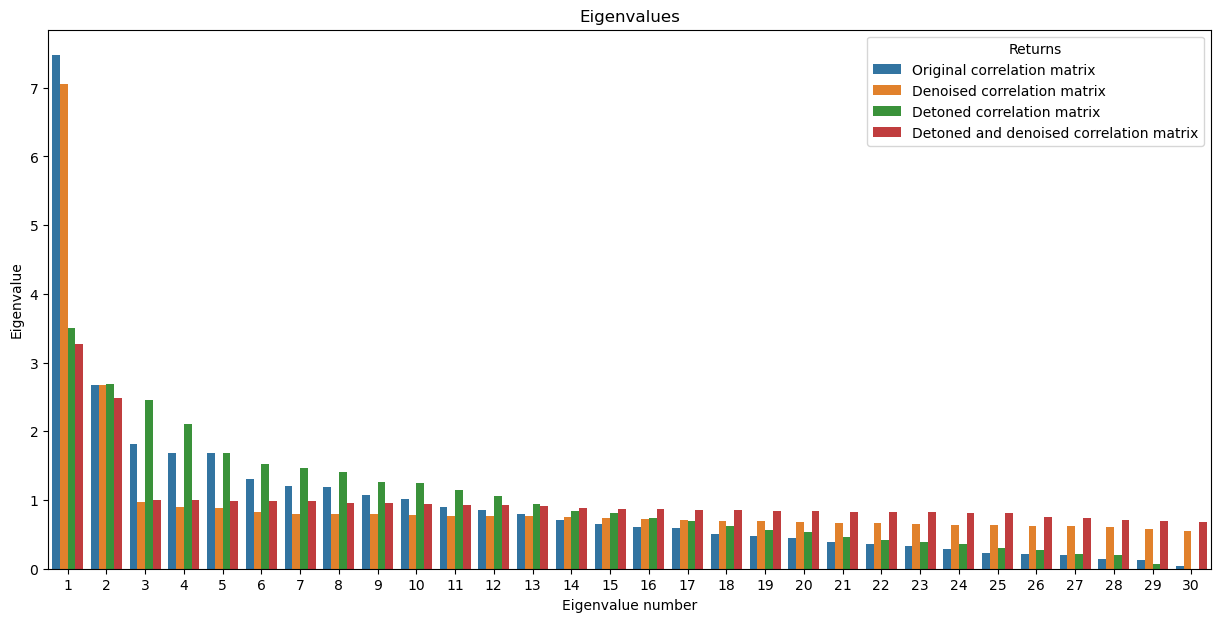

In [14]:
Sigma_detoned = detone(Sigma)

Sigma_denoised, remaining_denoised = denoise(correlations.returns, Sigma)
print(f'Remaining eigenvalues for denoised matrix: {remaining_denoised}')

Sigma_detoned_denoised, remaining_detoned_denoised = denoise_and_detone(correlations.returns, Sigma)
print(f'Remaining eigenvalues for detoned and denoised matrix: {remaining_detoned_denoised}')

plot_eigenvalues([Sigma, Sigma_denoised, Sigma_detoned, Sigma_detoned_denoised],
                  ['Original correlation matrix', 'Denoised correlation matrix', 'Detoned correlation matrix', 'Detoned and denoised correlation matrix'])

Sigma


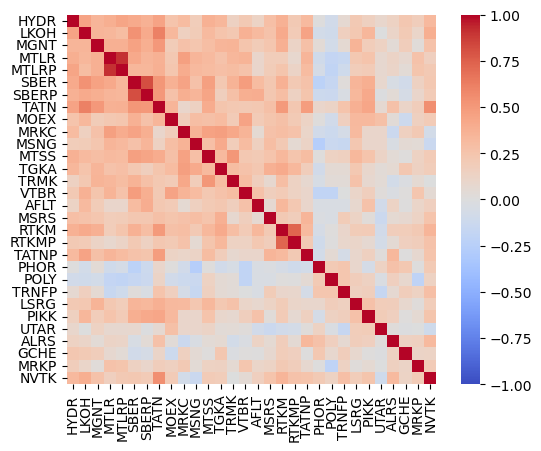

Sigma_denoised


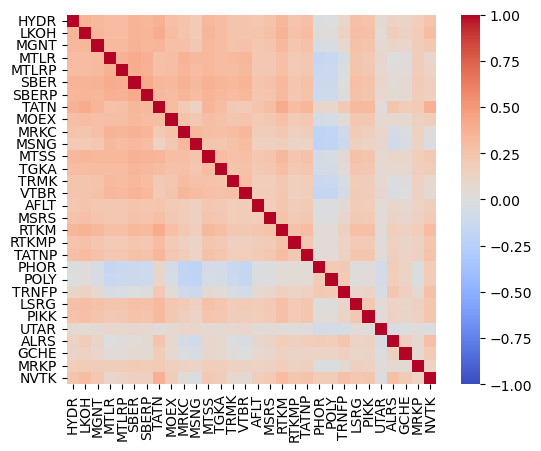

Sigma_detoned


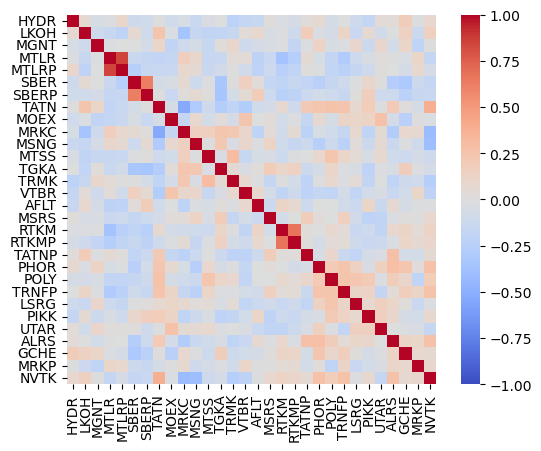

Sigma_detoned_denoised


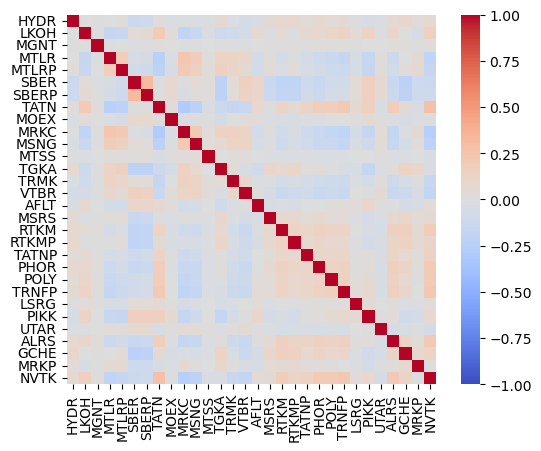

In [15]:
print(f'Sigma')
plot_correlations(Sigma, sorted_labels)
plt.savefig('../figures/sigmas/real.png', bbox_inches='tight')
plt.show()


print(f'Sigma_denoised')
plot_correlations(Sigma_denoised, sorted_labels)
plt.savefig('../figures/sigmas/denoised.png', bbox_inches='tight')
plt.show()

print(f'Sigma_detoned')
plot_correlations(Sigma_detoned, sorted_labels)
plt.savefig('../figures/sigmas/detoned.png', bbox_inches='tight')
plt.show()

print(f'Sigma_detoned_denoised')
plot_correlations(Sigma_detoned_denoised, sorted_labels)
plt.savefig('../figures/sigmas/detoned_denoised.png', bbox_inches='tight')
plt.show()

In [51]:
from library.correlations import get_correlation_matrices, N_REMAINING_COMPONENTS


correlations_train = get_correlation_matrices(observations_train, is_train=True)

print('Remaining number of eigenvalues in denoised matrix:')
print(pd.value_counts(correlations_train.n_remaining_components_denoised).sort_index())

print('\nRemaining number of eigenvalues in detoned and denoised matrix:')
print(pd.value_counts(correlations_train.n_remaining_components_detoned_denoised).sort_index())

Remaining number of eigenvalues in denoised matrix:
1    754
2    255
3      1
dtype: int64

Remaining number of eigenvalues in detoned and denoised matrix:
1    100
2    833
3     76
4      1
dtype: int64


In [52]:
correlations_train = get_correlation_matrices(observations_train, True, N_REMAINING_COMPONENTS, N_REMAINING_COMPONENTS)
assert np.all((np.array(correlations_train.n_remaining_components_denoised) == N_REMAINING_COMPONENTS) & (np.array(correlations_train.n_remaining_components_detoned_denoised) == N_REMAINING_COMPONENTS))
assert N_REMAINING_COMPONENTS == 2

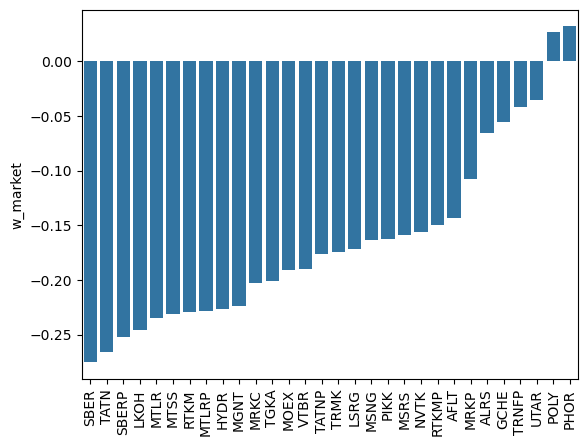

In [80]:
w_market = correlations_train.singular_vectors[OBSERVATION_NUMBER][0]
sorted_index = np.argsort(w_market)
columns = correlations_train.Sigmas[0].columns
sns.barplot(y=w_market[sorted_index], x=columns[sorted_index], color='C0')
plt.ylabel('w_market')
plt.xticks(rotation=90)
plt.savefig('../figures/market_components/first_component.png', bbox_inches='tight')
plt.show()

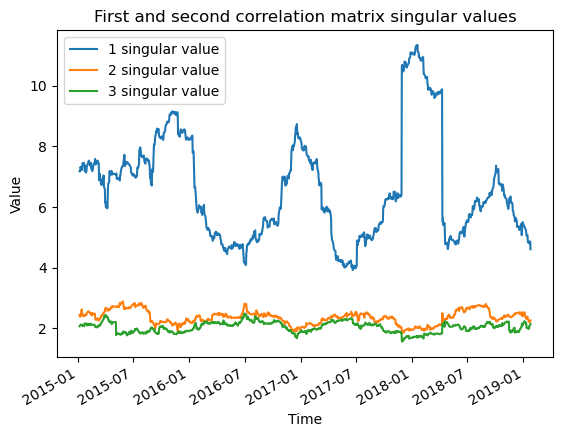

In [98]:
time_index = [r.index[0] for r in correlations_train.returns]
for i in range(3):
    singular_values = [values[i] for values in correlations_train.singular_values]
    sns.lineplot(x=time_index, y=singular_values, label=f'{i + 1} singular value')
plt.title('First and second correlation matrix singular values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [18]:
correlations_train_test = get_correlation_matrices(observations_train, is_train=False)

In [19]:
len(correlations_train_test.Sigmas)

1010

Run kmeans for Sigma


  0%|          | 0/17 [00:00<?, ?it/s]

Optimal clusters count:
2    11
3     3
4     3
dtype: int64


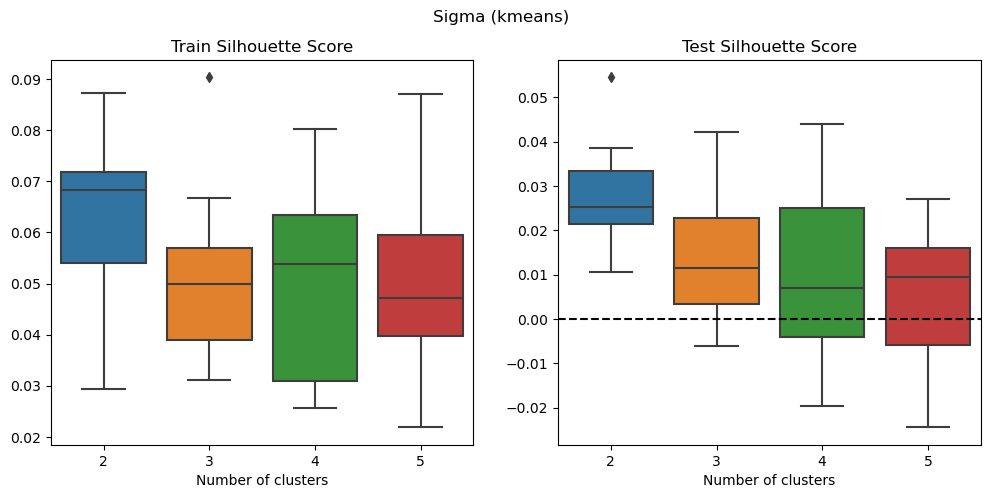

Run kmeans for Sigma denoised


  0%|          | 0/17 [00:00<?, ?it/s]

Optimal clusters count:
2    15
3     2
dtype: int64


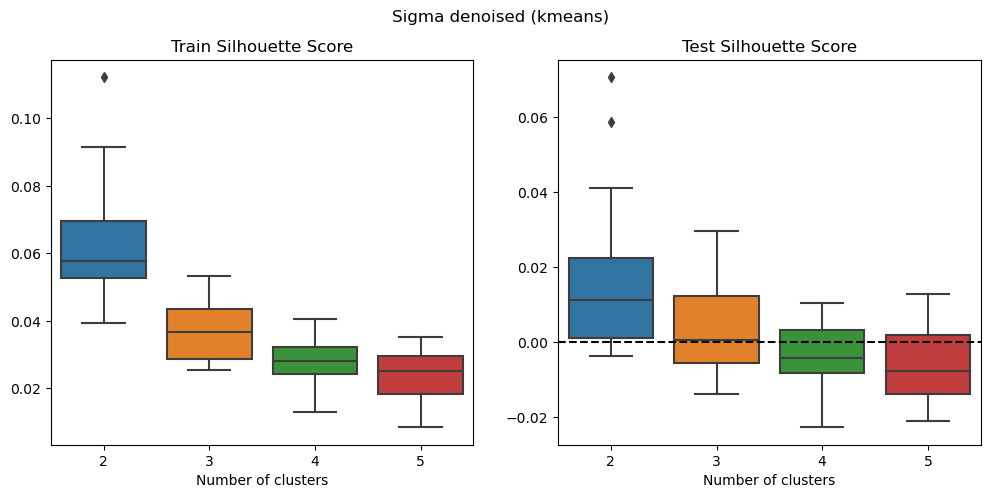

Run kmeans for Sigma detoned


  0%|          | 0/17 [00:00<?, ?it/s]

Optimal clusters count:
2    4
3    3
4    4
5    6
dtype: int64


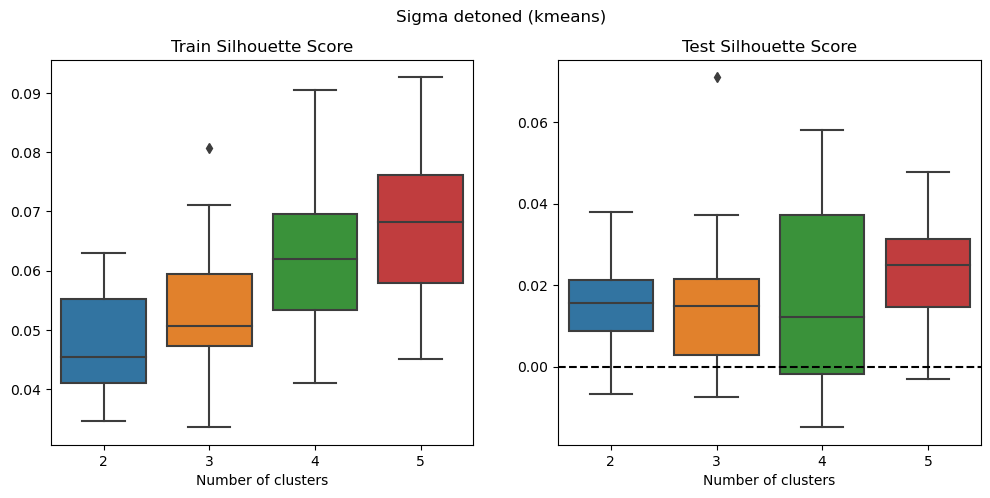

Run kmeans for Sigma detoned denoised


  0%|          | 0/17 [00:00<?, ?it/s]

Optimal clusters count:
2    17
dtype: int64


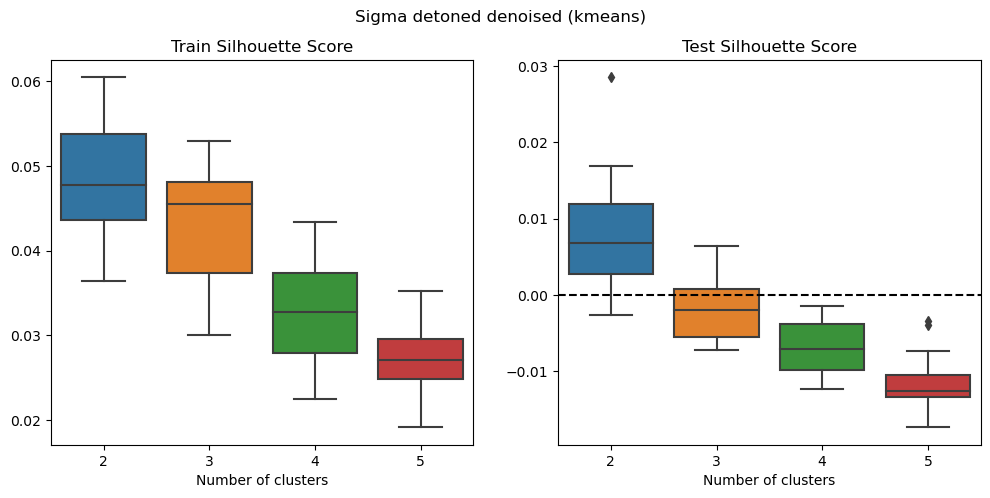

Run spectral for Sigma


  0%|          | 0/17 [00:00<?, ?it/s]

Optimal clusters count:
2    6
3    5
4    1
5    5
dtype: int64


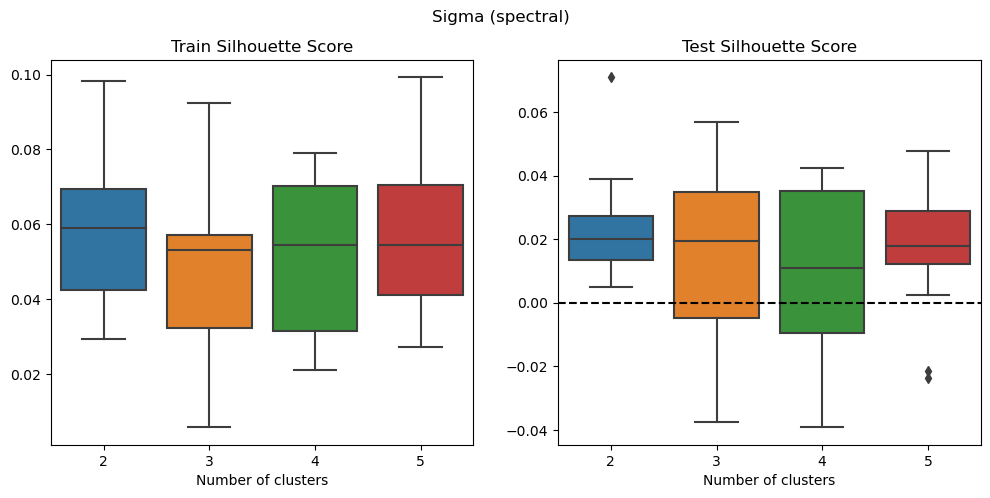

Run spectral for Sigma denoised


  0%|          | 0/17 [00:00<?, ?it/s]

Optimal clusters count:
2    16
3     1
dtype: int64


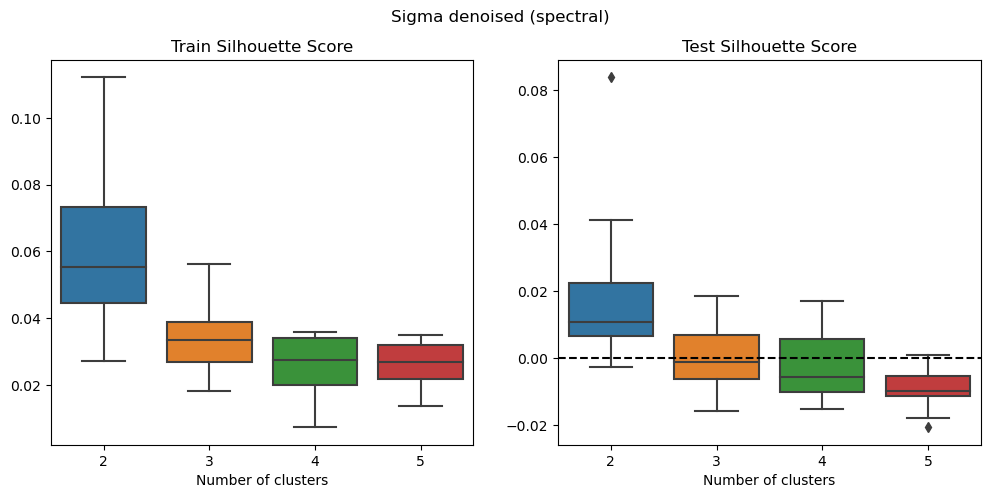

Run spectral for Sigma detoned


  0%|          | 0/17 [00:00<?, ?it/s]

Optimal clusters count:
2    3
3    3
4    6
5    5
dtype: int64


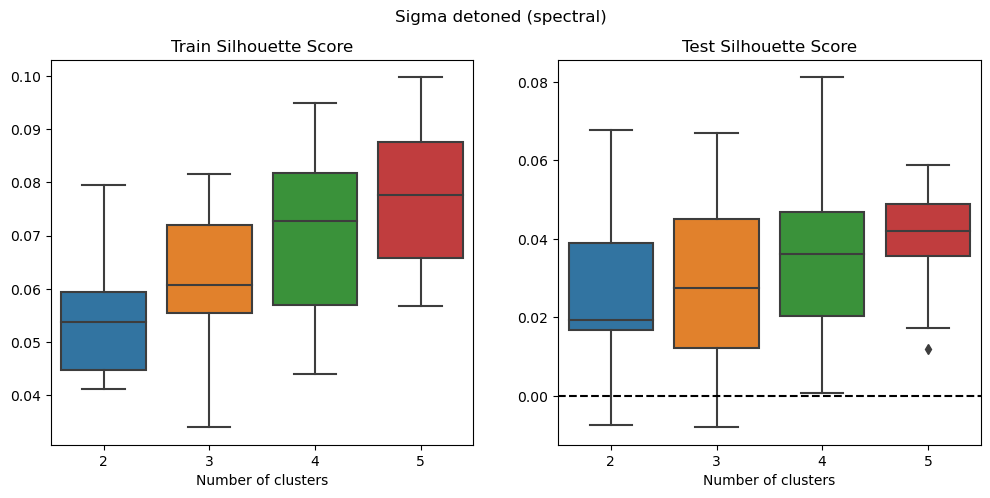

Run spectral for Sigma detoned denoised


  0%|          | 0/17 [00:00<?, ?it/s]

Optimal clusters count:
2    16
3     1
dtype: int64


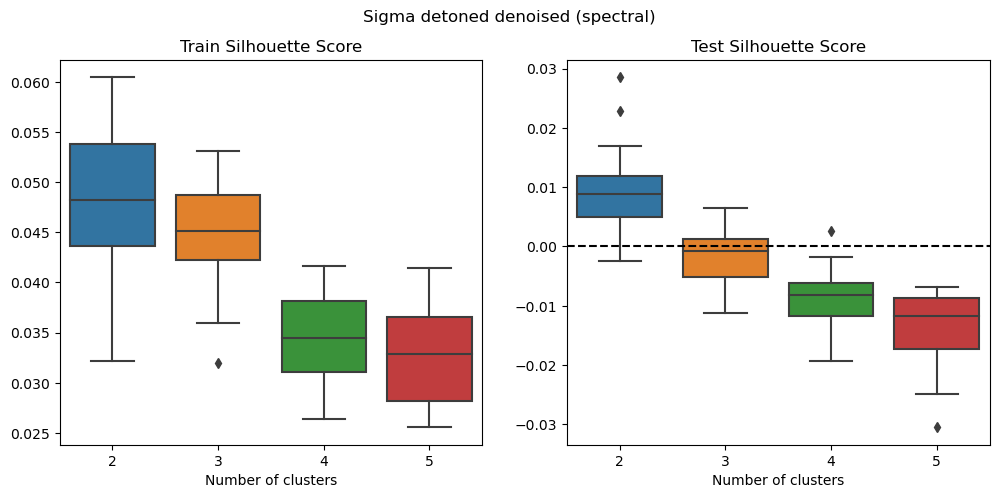

In [20]:
from library.clustering import find_optimal_clusters_number, plot_correlation_matrix_clusters
from tqdm.notebook import tqdm


def plot_silhouette_scores(n_clusters_list: list[int], silhouette_scores: list[list[int]]):
    sns.boxplot(np.array(silhouette_scores))
    plt.xticks(range(len(n_clusters_list)), n_clusters_list)


def run_models_for_sigmas(Sigmas_train: list[pd.DataFrame], Sigmas_test: list[pd.DataFrame], model: str, name: str):
    print(f'Run {model} for {name}')
    assert model in ['kmeans', 'spectral']
    n_clusters_list = list(range(2, 6))
    train_scores = []
    test_scores = []
    n_optimal_clusters = []
    for Sigma_train, Sigma_test in tqdm(list(zip(Sigmas_train, Sigmas_test))):
        result = find_optimal_clusters_number(Sigma_train, Sigma_test, n_clusters_list=n_clusters_list, model=model)
        train_scores.append(result.silhouette_train_scores)
        test_scores.append(result.silhouette_test_scores)
        n_optimal_clusters.append(result.best_n_clusters)
    print('Optimal clusters count:')
    print(pd.value_counts(n_optimal_clusters).sort_index())

    # Plot silhouette scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle(f'{name} ({model})')
    plt.subplot(1, 2, 1)
    plot_silhouette_scores(n_clusters_list, train_scores)
    plt.title('Train Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.subplot(1, 2, 2)
    plot_silhouette_scores(n_clusters_list, test_scores)
    plt.axhline(0.0, color='black', linestyle='dashed')
    plt.title('Test Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.show()

    # Plot clusters on train and test
    # plt.subplots(1, 2, figsize=(12, 5))
    # plt.subplot(1, 2, 1)
    # plot_correlation_matrix_clusters(Sigma_train, results.best_clusters_labels, print_clusters=True)
    # plt.title('Clusters on train data')
    # plt.subplot(1, 2, 2)
    # plot_correlation_matrix_clusters(Sigma_test, results.best_clusters_labels)
    # plt.title('Clusters on test data')
    # plt.show()


N_STEP = 60

for MODEL in ['kmeans', 'spectral']:
    run_models_for_sigmas(correlations_train.Sigmas[::N_STEP], correlations_train_test.Sigmas[::N_STEP], model=MODEL, name='Sigma')
    run_models_for_sigmas(correlations_train.Sigmas_denoised[::N_STEP], correlations_train_test.Sigmas_denoised[::N_STEP], model=MODEL, name='Sigma denoised')
    run_models_for_sigmas(correlations_train.Sigmas_detoned[::N_STEP], correlations_train_test.Sigmas_detoned[::N_STEP], model=MODEL, name='Sigma detoned')
    run_models_for_sigmas(correlations_train.Sigmas_detoned_denoised[::N_STEP], correlations_train_test.Sigmas_detoned_denoised[::N_STEP], model=MODEL, name='Sigma detoned denoised')

In [21]:
from scipy.cluster.hierarchy import (
    average,
    complete,
    fcluster,
    single,
    ward,
)
from library.correlations import _hierarchical_clustering

def sort_table(distance_matrix: pd.DataFrame) -> list[str]:
    linkage_matrix = _hierarchical_clustering(distance_matrix)

    cluster_labels = fcluster(linkage_matrix, 6, criterion="maxclust")

    sorted_cols_and_orders = sorted(
        list(zip(distance_matrix.columns, cluster_labels)), key=lambda x: x[1]
    )
    sorted_cols, _ = list(map(list, list(zip(*sorted_cols_and_orders))))
    return sorted_cols

In [22]:
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy


def get_n_bins(nObs, corr):
    # Optimal number of bins for discretization
    return 3
    return round(2**-.5*(1+(1+24*nObs/(1.-corr**2))**.5)**.5)


def var_info(x, y):
    # compute number of bins
    n_bins = get_n_bins(x.shape[0], corr=np.corrcoef(x, y)[0, 1])
    # get discrete joint distribution
    joint_discrete_distribution = np.histogram2d(x, y, n_bins)[0]
    x_distribution = np.histogram(x, n_bins)[0]
    y_distribution = np.histogram(y, n_bins)[0]
    # pass joint discrete distribution to compute I(X, Y)
    I_XY = mutual_info_score(None, None, contingency=joint_discrete_distribution)
    # compute H(X), H(Y)
    H_X = entropy(x_distribution)
    H_Y = entropy(y_distribution)
    # VI(X, Y) = H(X) + H(Y) - 2 * I(X, Y)
    VI = H_X + H_Y - 2 * I_XY
    # Normalize
    # H(X, Y) = H(X) + H(Y) - I(X, Y)
    H_XY = H_X + H_Y - I_XY
    VI /= H_XY
    assert np.isclose(VI, 1 - I_XY / H_XY)
    return VI


# def mutual_information(x, y):
#     # compute number of bins
#     n_bins = get_n_bins(x.shape[0], corr=np.corrcoef(x, y)[0, 1])
#     # get discrete joint distribution
#     joint_discrete_distribution = np.histogram2d(x, y, n_bins)[0]
#     x_distribution = np.histogram(x, n_bins)[0]
#     y_distribution = np.histogram(y, n_bins)[0]
#     # pass joint discrete distribution to compute I(X, Y)
#     I_XY = mutual_info_score(None, None, contingency=joint_discrete_distribution)
#     return I_XY

In [23]:
def get_var_info(returns):
    result = pd.DataFrame(columns=returns.columns, index=returns.columns, dtype=float)
    for col1 in returns.columns:
        for col2 in returns.columns:
            if col1 == col2:
                result.loc[col1, col2] = 0.0
                continue
            result.loc[col1, col2] = var_info(returns[col1], returns[col2])
    return result

# distances_train = get_var_info(get_returns_correlations(df_price_train).returns)
# distances_test = get_var_info(get_returns_correlations(df_price_test).returns)

distances_train = get_var_info(correlations_train_test.returns[OBSERVATION_NUMBER])
distances_test = get_var_info(correlations_train_test.returns[OBSERVATION_NUMBER])

<AxesSubplot:>

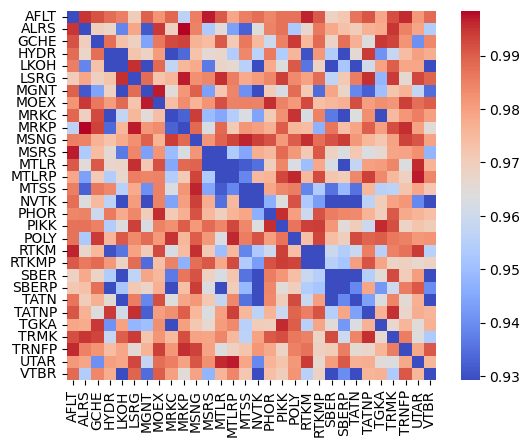

In [24]:
new_sorted_labels = sort_table(distances_train)

tmp = distances_train.copy()
bad_mask = tmp < tmp.mean().mean() - 10 * tmp.std().std()
value = tmp[~bad_mask].min().min()
tmp[bad_mask] = value
sns.heatmap(tmp, cmap='coolwarm', xticklabels=True, yticklabels=True, square=True)

<AxesSubplot:>

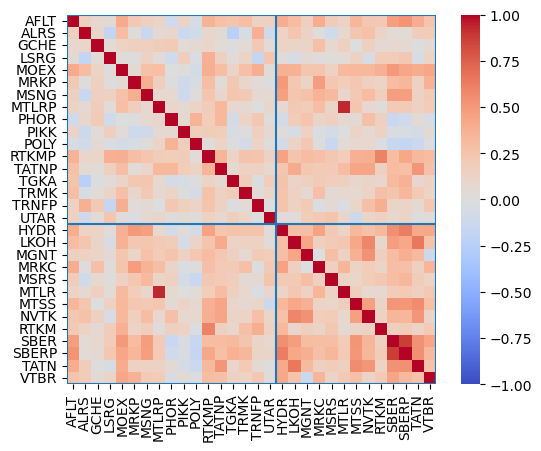

In [25]:
results = find_optimal_clusters_number(distances_train, distances_test, n_clusters_list=list(range(2, 6)), model='kmeans')
plot_correlation_matrix_clusters(correlations_train.Sigmas[0], results.best_clusters_labels)